# PVSC 2015

This notebook contains all of the code needed to reproduce the figures found in the **PVLIB Python 2015** manuscript and poster in the 42nd IEEE PVSC. It is not intended to be a comprehensive introduction to ``pvlib-python``. 

The manuscript and poster authors are William F. Holmgren, Robert W. Andrews, Antonio T. Lorenzo,
Joshua S. Stein.

Table of Contents
1. [Setup](#Setup)
2. [Single axis tracker](#Single-axis-tracker)
2. 

## Setup

The essential functionality requires:
* ``matplotlib``
* ``numpy``
* ``pandas``

The plotting library ``seaborn`` is needed to reproduce the figures exactly. You'll need to comment out any ``sns`` lines if you don't install ``seaborn``.

All of these packages can be easily installed using the conda package manager. To create a new conda environment to run this notebook, run these commands in your shell:

```
$ conda create -n pvlibpvsc python matplotlib numpy pandas seaborn ipython-notebook ephem
$ source activate pvlibpvsc
$ git clone https://github.com/pvlib/pvlib-python.git
$ cd pvlib-python
$ git checkout 621ad97
$ pip install .
$ ipython-notebook
```

First, the standard scientific Python imports. 

In [6]:
# plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_style('ticks')
    sns.set_context('notebook', font_scale=1.5)
except ImportError:
    pass
    
# built in python modules
import datetime

# python add-ons
import numpy as np
import pandas as pd

Import pvlib

In [2]:
import pvlib
from pvlib.location import Location
pvlib.__version__

'0.2.0dev'

Make some pvlib ``Location`` objects. These objects are convenient ways to keep track of coordinates, time zones, and elevations.

In [31]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
print(tus)
abq = Location(35, -106, tz='US/Mountain', altitude=1619, name='Albuquerque')
print(abq)
johannesburg = Location(-26.2044, 28.0456, 'Africa/Johannesburg', 1753, 'Johannesburg')
print(johannesburg)

Tucson: latitude=32.2, longitude=-111, tz=US/Arizona, altitude=700
Albuquerque: latitude=35, longitude=-106, tz=US/Mountain, altitude=1619
Johannesburg: latitude=-26.2044, longitude=28.0456, tz=Africa/Johannesburg, altitude=1753


In [19]:
# Boolean to control saving the figures.
# You'll need to change the directories if you want to save them.
save = True

## Single axis tracker

Simulation of single axis tracker output near Albuquerque, NM (figure 1).

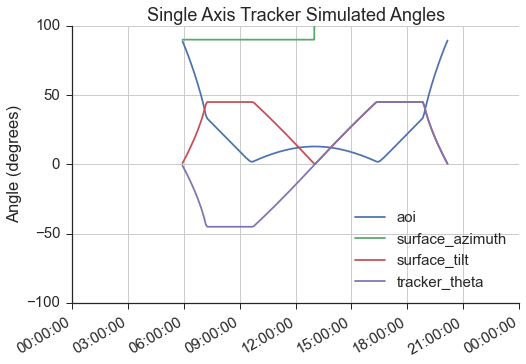

In [29]:
times = pd.date_range(start=datetime.datetime(2015,6,1), end=datetime.datetime(2015,6,2), freq='5Min')

solpos = pvlib.solarposition.get_solarposition(times, abq)

tracker_data = pvlib.tracking.singleaxis(solpos['apparent_zenith'], solpos['azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=45,
                                         backtrack=True, gcr=.3)

tracker_data.plot()
plt.ylim(-100,100)
plt.ylabel('Angle (degrees)')
plt.title('Single Axis Tracker Simulated Angles')
sns.despine()

if save: plt.savefig('/home/will/git_repos/pvsc2015/abq-tracker.eps', format='eps')

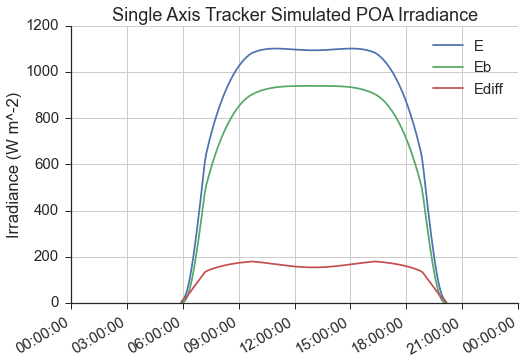

In [30]:
irrad_data = pvlib.clearsky.ineichen(times, abq)

dni_et = pd.Series(pvlib.irradiance.extraradiation(times.dayofyear, method='asce'), index=times).tz_localize(abq.tz)

ground_irrad = pvlib.irradiance.grounddiffuse(tracker_data['surface_tilt'], irrad_data['GHI'], albedo=.25)

haydavies_diffuse = pvlib.irradiance.haydavies(tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['DHI'], irrad_data['DNI'], dni_et,
                                                solpos['apparent_zenith'], solpos['azimuth'])

global_in_plane = pvlib.irradiance.globalinplane(tracker_data['aoi'], irrad_data['DNI'], 
                                                 haydavies_diffuse, ground_irrad)
global_in_plane.plot()
sns.despine()
plt.ylabel('Irradiance (W m^-2)')
plt.title('Single Axis Tracker Simulated POA Irradiance')

if save: plt.savefig('/home/will/git_repos/pvsc2015/abq-tracker-irrad.eps', format='eps')

## SAPM

Some simulations using the Sandia Array Performance Model

In [51]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')
#sandia_modules

Choose a random model from another pvlib-python tutorial.

In [36]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                   2009
Area                                                     1.701
Material                                                  c-Si
#Series                                                     96
#Parallel                                                    1
Isco                                                   5.09115
Voco                                                   59.2608
Impo                                                   4.54629
Vmpo                                                   48.3156
Aisc                                                  0.000397
Aimp                                                  0.000181
C0                                                     1.01284
C1                                                  -0.0128398
Bvoco                                                 -0.21696
Mbvoc                                                        0
Bvmpo                                                -0

Recalculate simulation parameters for a new location and a fixed tilt system.

In [70]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
times = pd.date_range(start=datetime.datetime(2015,4,1), end=datetime.datetime(2015,4,2), freq='30s')
solpos = pvlib.solarposition.get_solarposition(times, tus)
irrad_data = pvlib.clearsky.ineichen(times, tus)

aoi = pvlib.irradiance.aoi(tus.latitude, 180, solpos['apparent_zenith'], solpos['azimuth'])
#plt.figure()
#aoi.plot()

am = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])

# a hot, sunny spring day in the desert. no wind.
temps = pvlib.pvsystem.sapm_celltemp(irrad_data['GHI'], 0, 30)

sapm_1 = pvlib.pvsystem.sapm(sandia_module, irrad_data['DNI']*np.cos(np.radians(aoi)),
                     irrad_data['DHI'], temps['tcell'], am, aoi)
#sapm_1.head()

Make a reusable plotting function to generate a nice panel.

In [67]:
def plot_sapm(sapm_data):
    """
    Makes a nice figure with the SAPM data.
    
    Parameters
    ----------
    sapm_data : DataFrame
        The output of ``pvsystem.sapm``
    """
    fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=False, sharey=False, squeeze=False)
    plt.subplots_adjust(wspace=.3, hspace=.4)

    ax = axes[0,0]
    sapm_data.filter(like='I').plot(ax=ax)
    ax.set_ylabel('Current (A)')

    ax = axes[0,1]
    sapm_data.filter(like='V').plot(ax=ax)
    ax.set_ylabel('Voltage (V)')

    ax = axes[0,2]
    sapm_data.filter(like='P').plot(ax=ax)
    ax.set_ylabel('Power (W)')

    ax = axes[1,0]
    [ax.plot(sapm_data['Ee'], current, label=name) for name, current in sapm_data.filter(like='I').items()]
    ax.set_ylabel('Current (A)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    ax = axes[1,1]
    [ax.plot(sapm_data['Ee'], voltage, label=name) for name, voltage in sapm_data.filter(like='V').items()]
    ax.set_ylabel('Voltage (V)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=4)

    ax = axes[1,2]
    ax.plot(sapm_data['Ee'], sapm_data['Pmp'], label='Pmp')
    ax.set_ylabel('Power (W)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    # needed to show the time ticks
    for ax in axes.flatten():
        for tk in ax.get_xticklabels():
            tk.set_visible(True)
    
    return fig

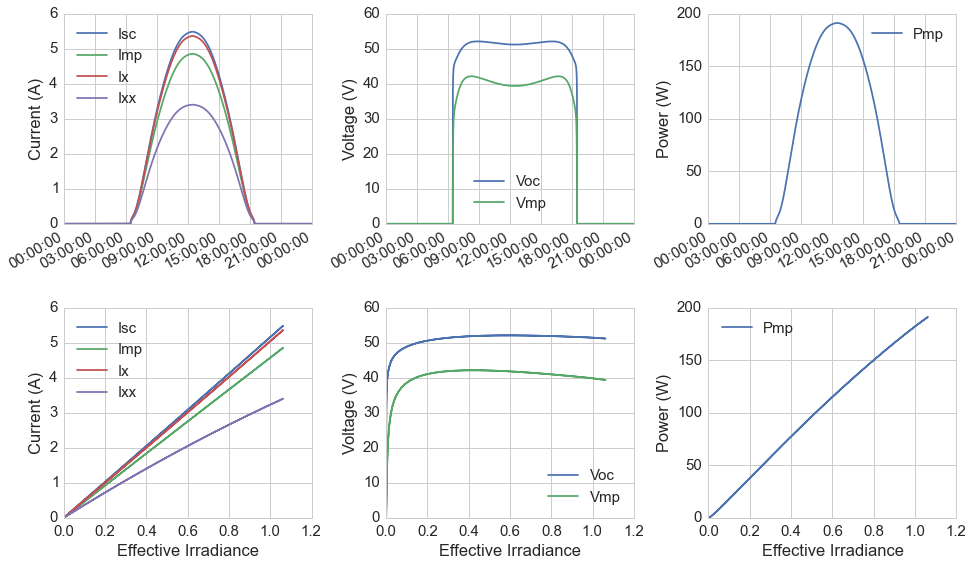

In [68]:
with sns.axes_style('whitegrid'):
    fig = plot_sapm(sapm_1)
    #sns.despine(fig=fig)
    if save: fig.savefig('/home/will/git_repos/pvsc2015/fixed_sapm.eps', format='eps')